In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import path
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


##  **Getting train and test data**

In [68]:
train_df= pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test_df = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

From the above data we can observe that there are both kinds of variables present in the feature
1. Categorical Variables
2. Numerical Variables
1st caegory includes columns: season, holiday, working_day, datetime, 
2nd category includes columns: temp, atmep, humidity, windspeed, registered, causal

## Checking the number of unique number for categorical variables

In [69]:
map_to_uniqueness = {}
for cols in train_df.columns: 
    map_to_uniqueness[cols] = train_df[cols].nunique()
print(map_to_uniqueness)


{'datetime': 10886, 'season': 4, 'holiday': 2, 'workingday': 2, 'weather': 4, 'temp': 49, 'atemp': 60, 'humidity': 89, 'windspeed': 28, 'casual': 309, 'registered': 731, 'count': 822}


### Checking null values

In [70]:
null_values = {}
for cols in train_df.columns:
    null_values[cols] = train_df[cols].isnull().sum()
print(null_values)


{'datetime': 0, 'season': 0, 'holiday': 0, 'workingday': 0, 'weather': 0, 'temp': 0, 'atemp': 0, 'humidity': 0, 'windspeed': 0, 'casual': 0, 'registered': 0, 'count': 0}


There are no null values in any column. Yayy! We are good to go without bothering about imputations and methods!

## Taking care of datetime series

1.2420662117180776


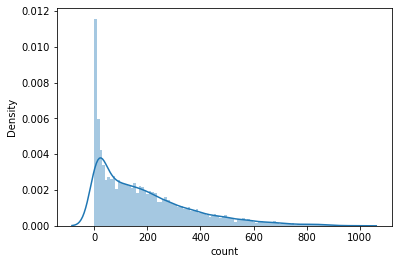

In [71]:
import seaborn as sns
sns.distplot(train_df['count'], bins = 100);
print(train_df["count"].skew())

train_df.datetime = pd.to_datetime(train_df.datetime)
train_df["month"] = train_df.datetime.dt.month
train_df["year"] = train_df.datetime.dt.year
train_df["hour"] = train_df.datetime.dt.hour

test_df.datetime = pd.to_datetime(test_df.datetime)
test_df["month"] = test_df.datetime.dt.month
test_df["year"] = test_df.datetime.dt.year
test_df["hour"] = test_df.datetime.dt.hour

We can see that data is not normally distributed so we need to take care of skewness and transform out target variable to a normal distributed target variable. It might also come to mind that why I did not create another column of day but but but since it is already given in the question statemnet that for the training data the days would be from 1 to 19 and for test data, it would be 20 above and since datetime series comes under categorical variable so while one hot encoding training and test variable the two different categories will create a problem for us and we want to simple model.

## Let's draw some correlation from the data

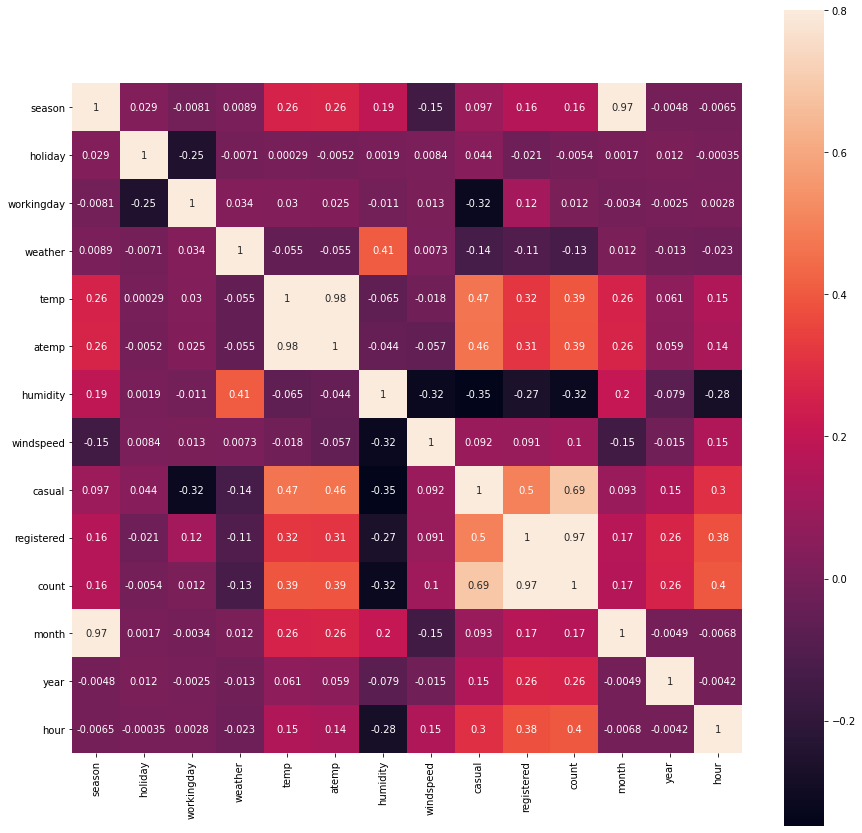

In [72]:
import matplotlib.pyplot as plt
cor = train_df.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(cor, vmax=.8, square=True, annot= True);

We can see that there a correlation between temp and atemp so we don't need both of them. Looking at the correlation we can also see that registered has a string correlation with target i.e count and causal has a strong correlation with registred so we do not need both of them. Let's get rid of them!

## Let's do some feature analysis

In [73]:
# Removing colums from train which are not in test_df and column which are too much correlated with some other variable
cols = ["casual", "registered", "atemp", "datetime"]
train_df = train_df.drop(cols, axis=1)
test_df = test_df.drop(["atemp", "datetime"], axis =1)
y = train_df.pop("count")

## Let's have a look at the histogram!

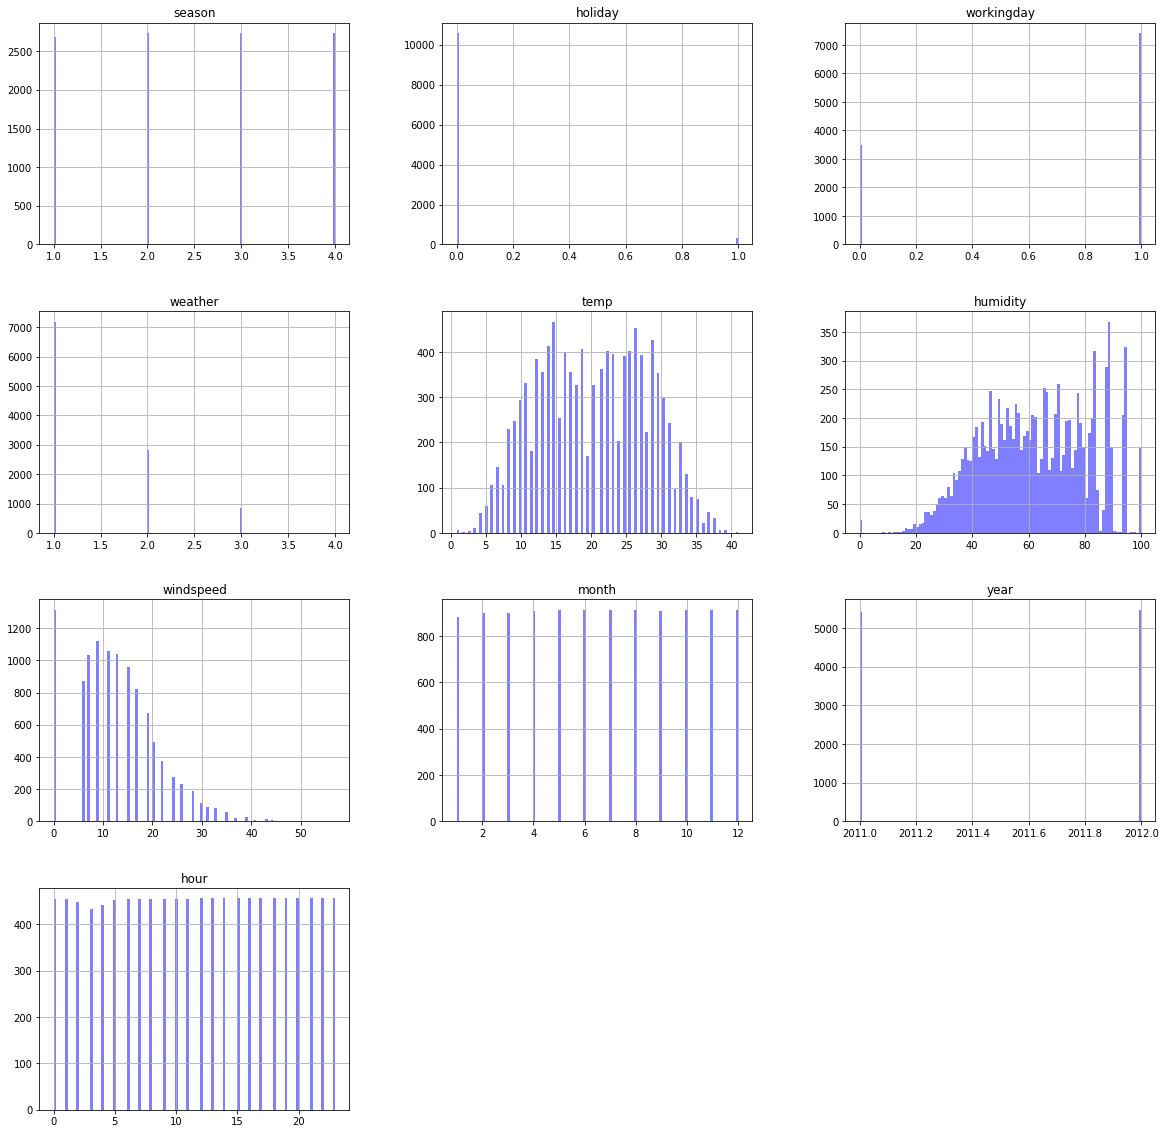

311
10575


In [74]:
# Draw a histogram of training data

train_cols = [col for col in list(train_df)]
train_df[train_cols].hist(figsize=(20,20), bins=100, color='blue', alpha=0.5)
plt.show()

# Just to take a quicklook at the data by looking at their distributions

print(len(train_df[train_df["holiday"] == 1].holiday))
print(len(train_df[train_df["holiday"] == 0].holiday))


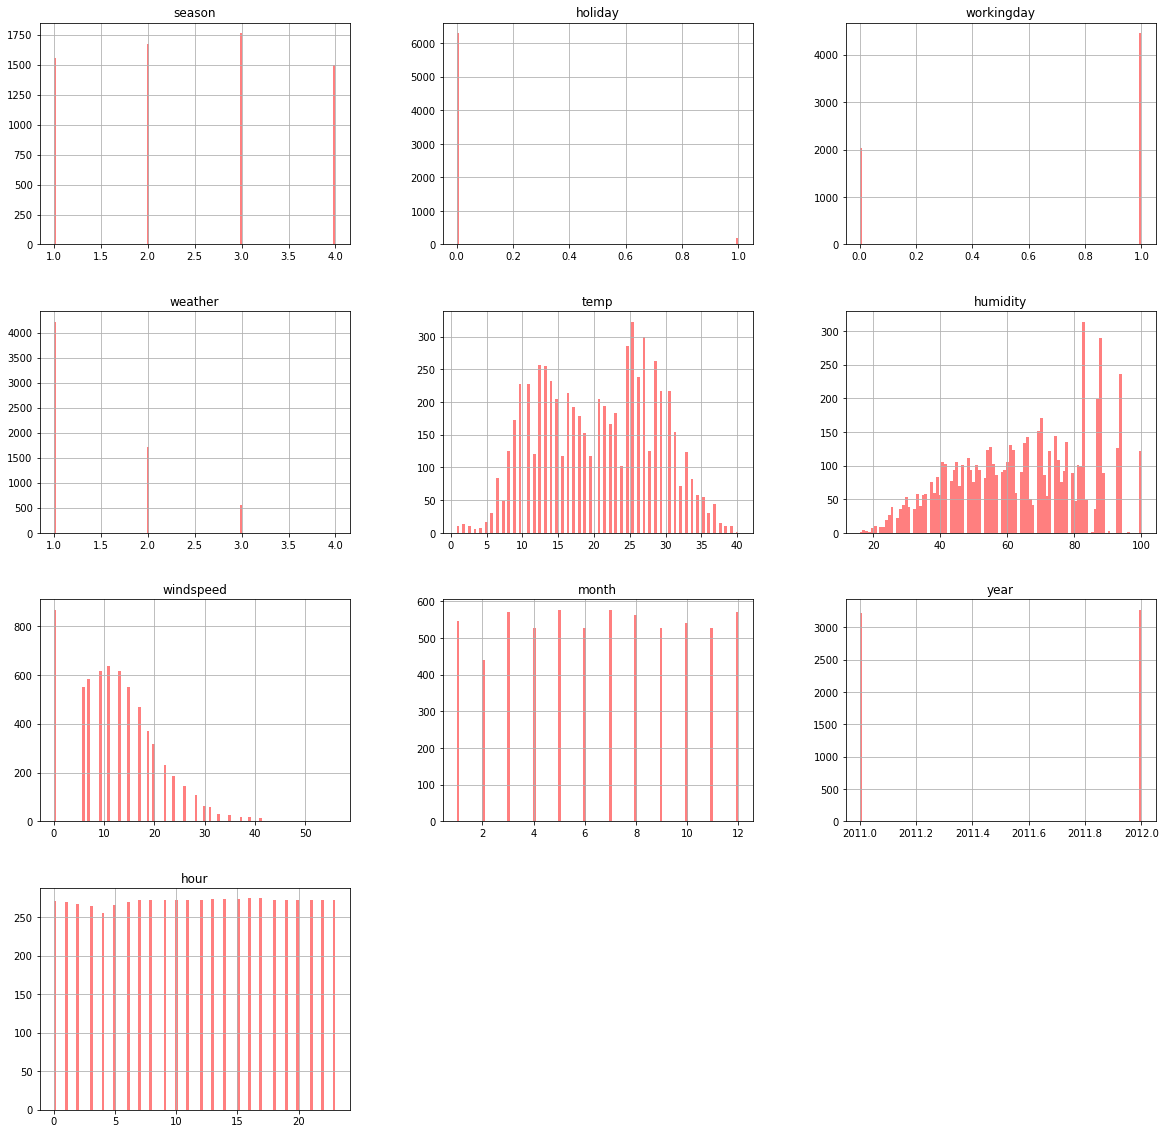

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
       'windspeed', 'month', 'year', 'hour'],
      dtype='object')


In [75]:

test_cols = [col for col in list(test_df)]
test_df[test_cols].hist(figsize=(20,20), bins=100, color='red', alpha=0.5)
plt.show()
print(test_df.columns)

We can see from above histograms that both the test data and train data are distributed in pretty much the same way.

In [76]:
#standardizing data
from sklearn.preprocessing import StandardScaler

### Let's look for bivariate variables

From above we feel tempted to get rid of few of the outliers. We can say that temp>40 falls prey to outlier category and so is windspeed>50 and when weather is of 4th category that is in winters. We will say, it's not worth it, let's live with it

In search of Normality!

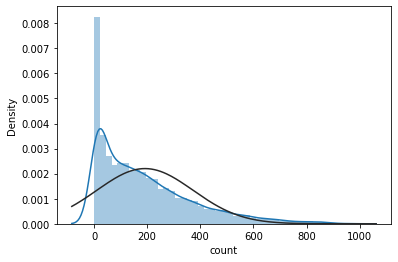

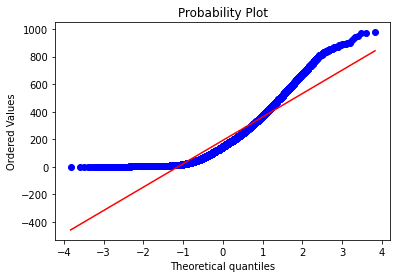

In [77]:

from scipy.stats import norm
from scipy import stats
sns.distplot(y, fit=norm);
fig = plt.figure()
res = stats.probplot(y, plot=plt)



### Splitting categorical and numerical data

In [78]:
numerical_cols = ["windspeed", "temp", "humidity"]
cat_cols = [cols for cols in train_df.columns.to_list() if cols not in numerical_cols]

In [79]:
train_df[cat_cols] = train_df[cat_cols].astype('category')
test_df[cat_cols] = test_df[cat_cols].astype('category')

## Splitting the data into train and test set

In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, random_state=5, test_size = 0.2)
"""
cols = ["temp", "humidity", "windspeed"]
for col in cols:
    X_train[cols] = np.log1p(X_train[cols]) 
    X_valid[cols] = np.log1p(X_valid[cols])
    refined_test_df[cols] = np.log1p(refined_test_df[cols])   
"""


'\ncols = ["temp", "humidity", "windspeed"]\nfor col in cols:\n    X_train[cols] = np.log1p(X_train[cols]) \n    X_valid[cols] = np.log1p(X_valid[cols])\n    refined_test_df[cols] = np.log1p(refined_test_df[cols])   \n'

### Transforming the train and validation data to make their distribution normal

In [81]:
y_train = np.log1p(y_train) 
y_valid = np.log1p(y_valid)
print(X_train.shape)
print(X_valid.shape)

(8708, 10)
(2178, 10)


## Model tarining

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
])
full_pipeline = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_cols),
    ('num', num_pipeline, numerical_cols)
])


X_train_prepared = full_pipeline.fit_transform(X_train)
X_valid_prepared = full_pipeline.transform(X_valid)

print(X_train_prepared.shape)
print(X_valid_prepared.shape)

xg = XGBRegressor(random_state = 0, learning_rate = 0.2, n_estimators = 150)

xg.fit(X_train_prepared, y_train)
y_pred = xg.predict(X_valid_prepared)
y_train_pred = xg.predict(X_train_prepared)
     
print("These are rmsle for train and validation sets {}, {}"
      .format(np.sqrt(mean_squared_log_error(y_train_pred, y_train)), 
              np.sqrt(mean_squared_log_error(y_pred, y_valid))
             ))

(8708, 53)
(2178, 53)
These are rmsle for train and validation sets 0.05072959282080989, 0.08699612541102536


In [83]:

X_test_prepared = full_pipeline.transform(test_df)
res  = xg.predict(X_test_prepared)
print(res)
res = np.expm1(res).astype(int)
print(res)

[2.2079437 1.7923802 1.4818394 ... 4.8124657 4.5354347 3.890861 ]
[  8   5   3 ... 122  92  47]


In [84]:
submission = pd.read_csv("/kaggle/input/bike-sharing-demand/sampleSubmission.csv")

In [85]:
output = pd.DataFrame({'datetime': submission.datetime,
                       'count': res })
print(output.shape)
output.to_csv('submission.csv', index=False)

(6493, 2)
